![](../logo.png)

# Robust linear regression
## Yoav Ram

In this assignment we will estimate not only the parameters of a linear model but also estimate the probability that each data point is an outlier.

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as np
import jax
from jax import random
from jax.scipy.special import expit, logit
from jax.scipy import stats
from scipy import optimize
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
red, blue, green = sns.color_palette('Set1', 3)

Consider the following dataset.

In [37]:
df = pd.read_csv('../data/outliers.csv')
df.head()

,x,y
0,0,23.715417
1,3,64.343713
2,9,33.164727
3,14,32.338875
4,15,38.264633


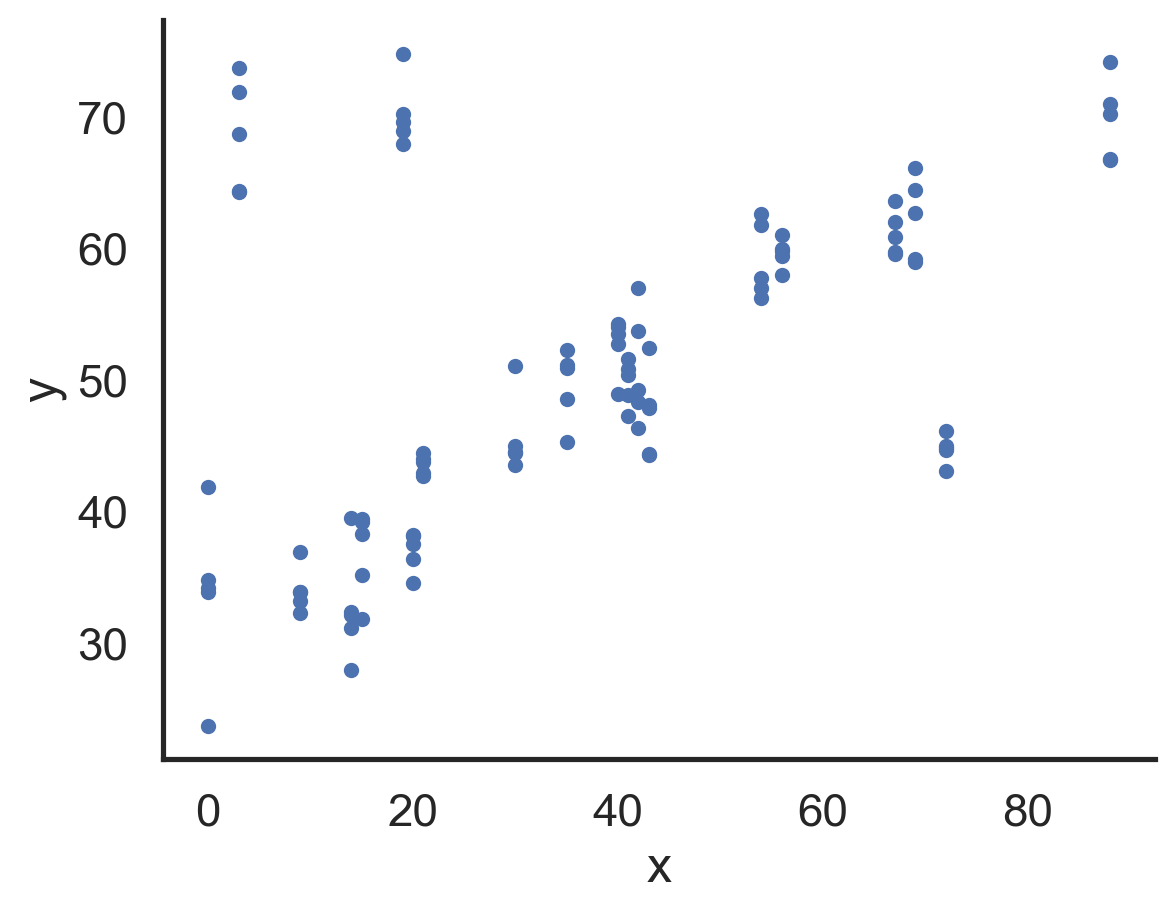

In [38]:
X = df['x'].values
Y = df['y'].values
plt.plot(X, Y, '.')
plt.xlabel('x')
plt.ylabel('y')
sns.despine()

There are several `y` measurements for each `x` value. 
We therefore compute the mean and standard deviation for `y` at each `x` value, and assign the mean back to `y` and the standard deviation to `e`.

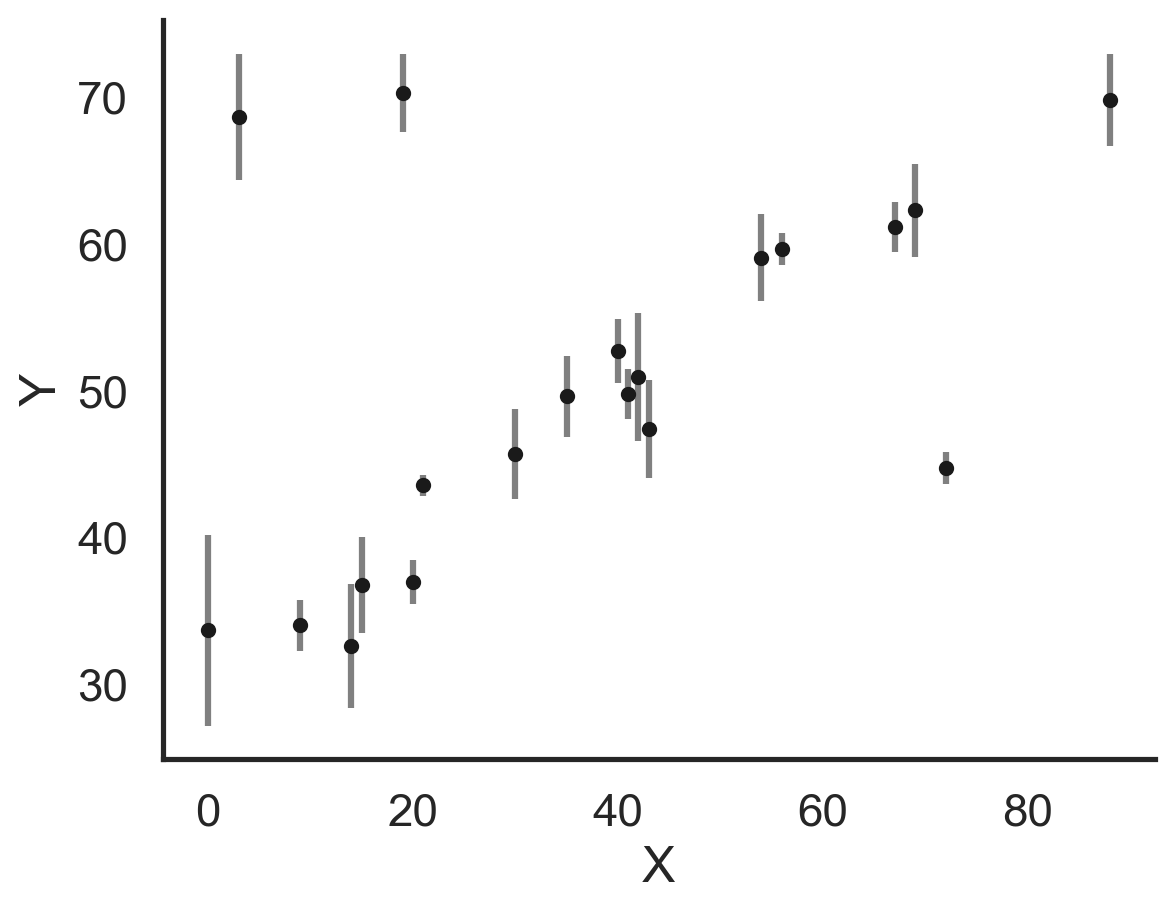

In [39]:
e = df.groupby('x')['y'].std(ddof=1).values
Y = df.groupby('x')['y'].mean().values
X = np.unique(X)

def plot_data():
    plt.errorbar(X, Y, yerr=e, fmt='.k', ecolor='gray')
    plt.xlabel('X')
    plt.ylabel('Y')
    sns.despine()
    
plot_data()

We can observe something similar to a linear relationship between `x` and `y`, but with some outliers, especially in the top left corner.

We would like to find a linear model that fits the data. 

The straightforward approach is that of the normal linear model:

$$
\hat{y}_i = a x_i + b $$$$
y_i \sim N(\hat{y}_i, e_i)
$$

Here, we use the estimates `e` for the standard deviation $\sigma_i$ at data point $i$.
This can provide a better model fit compared to estimating a single $\sigma$ parameter for all `x` values, especially when some of the points are outliers.

# Maximum likelihood estimation
We first find the parameters $\theta=(a, b)$ that minimize the negative log-likelihood, or the loss function, by implementing the loss function (`NLL_norm`) and minimizing it.

Remember that maximizing the likelihood = maximizing the log-likelihood = minimizing the negative log-likelihood = miniziming the loss function.

Here, we use `e` to standardize the residuals: look at the role of $\sigma$ in the original probability density function of the normal distribution. So the loss is
$$
NLL(a, b) = \frac{1}{n}\sum_{i=1}^{2n}{\frac{(\hat{y}_i-y_i)^2}{e_i^2}}
$$

In [41]:
def NLL_norm(θ, X, Y, e): 
    a, b = θ
    Yhat = a * X + b
    resid = Yhat - Y
    resid /= e
    return 0.5 * (resid * resid).sum()

In [42]:
θ_guess = 35, 0.25 # my initial guess from looking at the figure
print(NLL_norm(θ_guess, X, Y, e)) 

7315728.0


In [44]:
result = optimize.minimize(
    NLL_norm,
    θ_guess,
    method='L-BFGS-B',
    jac=jax.grad(NLL_norm),
    args=(X, Y, e)
)
print(result.success, result.message)
θ_norm = result.x
print("Nomral linear model:\n a={:.2f}, b={:.2f}".format(*θ_norm))

True CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Nomral linear model:
 a=0.23, b=39.47


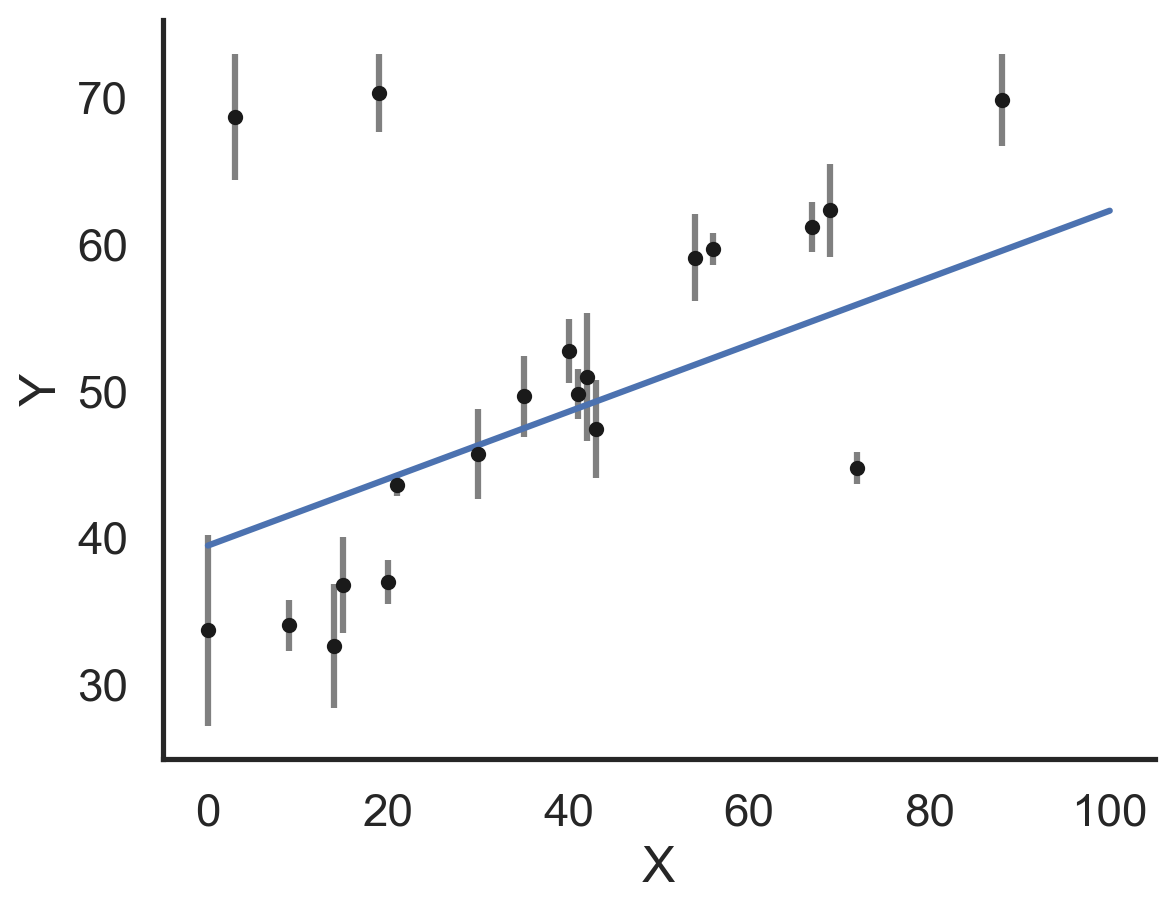

In [45]:
a, b = θ_norm
x_range = np.linspace(0, 100)

plot_data()
plt.plot(x_range, a * x_range + b, '-');

It's clear on examination that the outliers are exerting a disproportionate influence on the model fit.
This is due to the nature of the squared loss function.
If you have a single outlier that is 10 standard deviations away from the model lines its contribution to the loss will out-weigh that of 25 points which are 2 standard deviations away!

# Huber linear model for outlier correction

The variety of possible loss functions is quite literally infinite, but one relatively well-motivated option is the [Huber loss](http://en.wikipedia.org/wiki/Huber_loss_function). The Huber loss defines a critical value at which the loss curve transitions from quadratic to linear.
$$
f_{\delta}(z)=\left\{\begin{array}{ll}
\frac{1}{2} z^{2} & \text { for }|z| \leq \delta \\
\delta\left(|z|-\frac{1}{2} \delta\right), & \text { otherwise }
\end{array}\right.
$$

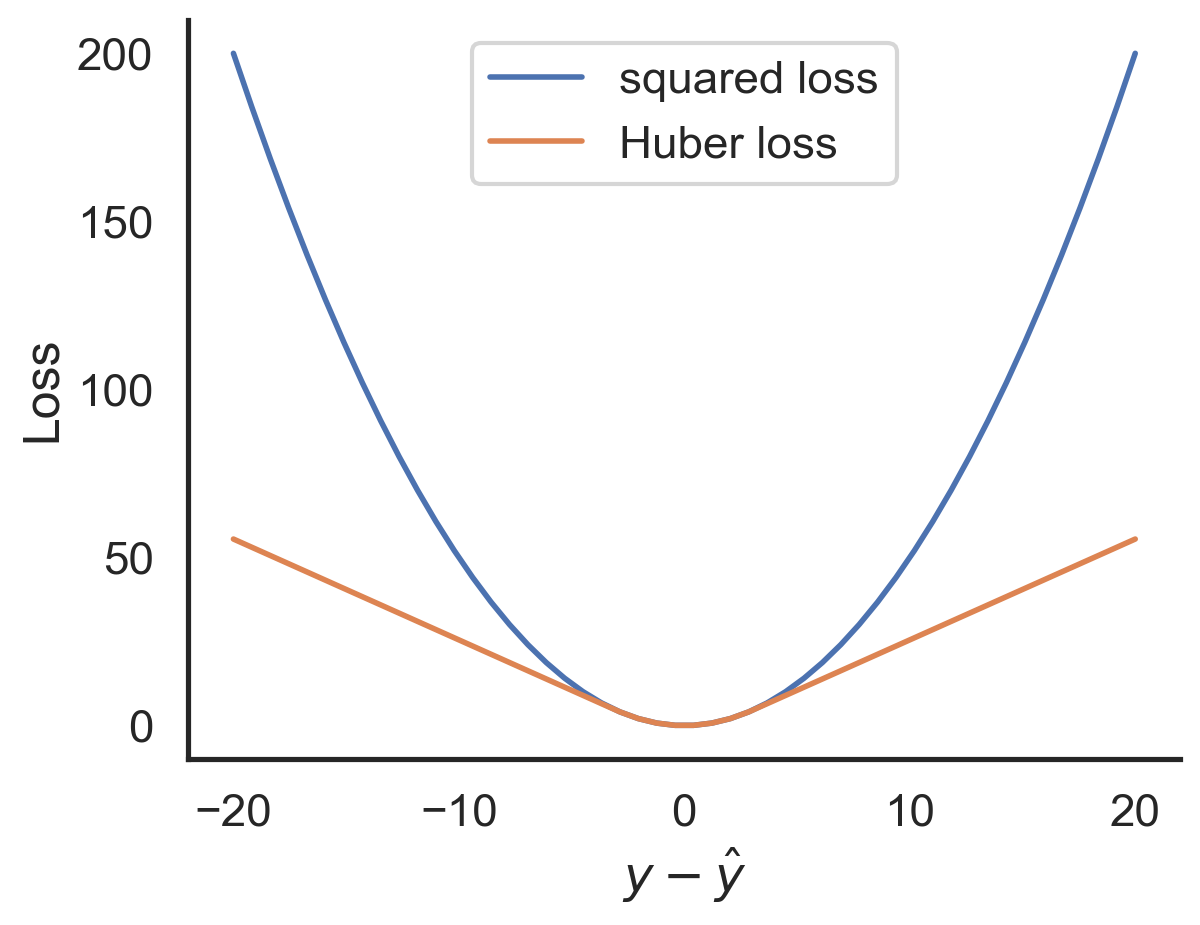

In [46]:
def huber(z, δ=3):
    return (
        (abs(z) < δ) * 0.5 * z * z +
        (abs(z) >= δ) * -δ * (0.5 * δ - abs(z)))

z = np.linspace(-20, 20)
plt.plot(z, 0.5 * z * z, label="squared loss", lw=2)
plt.plot(z, huber(z), label="Huber loss", lw=2)
plt.legend()
plt.xlabel(r'$y-\hat{y}$')
plt.ylabel('Loss')
sns.despine()

We implement the `NLL_huber` loss function, which is similar to the nagative log-likelihood we implemented for the normal model, except that it uses the `huber` function instead of taking the square of the residuals.

In [48]:
def NLL_huber(θ, X, Y, e, δ=3): 
    a, b = θ
    Yhat = a * X + b
    resid = Yhat - Y
    resid /= e
    return huber(resid, δ).sum()

print(NLL_huber(θ_guess, X, Y, e)) 

37879.676


Now we find the `a` and `b` values that minizime `NLL_huber`.

In [49]:
result = optimize.minimize(
    NLL_huber,
    θ_guess,
    method='L-BFGS-B',
    jac=jax.grad(NLL_huber),
    args=(X, Y, e)
)
print(result.success, result.message)
θ_huber = result.x
print("Huber linear model:\n a={:.2f}, b={:.2f}".format(*θ_huber)) 

True CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Huber linear model:
 a=0.39, b=34.73


Now we plot the data with the two model fits. 

The code below plots the data, the normal and the Huber models.

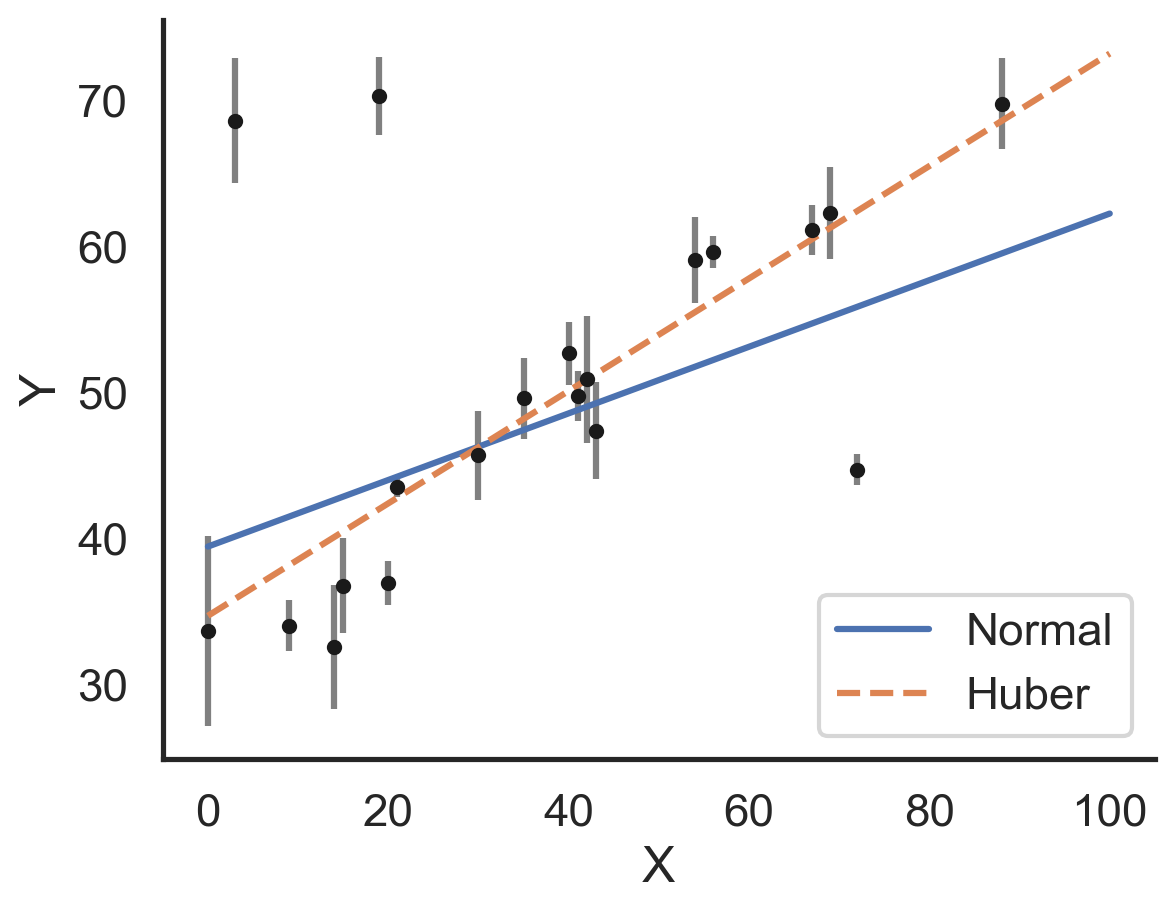

In [50]:
x_range = np.linspace(0, 100) 

plot_data() 
a, b = θ_norm
plt.plot(x_range, a * x_range + b, '-', label='Normal')
a, b = θ_huber
plt.plot(x_range, a * x_range + b, '--', label='Huber')
plt.legend();

By eye, this seems to have worked as desired: the fit is much closer to our intuition!

However a Bayesian might point out that the motivation for this new loss function is a bit suspect: as we showed, the squared-loss can be straightforwardly derived from a Gaussian likelihood. The Huber loss seems a bit *ad hoc*: where does it come from? How should we decide what value of $\delta$ to use? Is there any good motivation for using a linear loss on outliers, or should we simply remove them instead? How might this choice affect our resulting model?

# Robust linear regression: nuisance parameters

A model-based approach to accounting for outliers generally involves *modifying the model*.
We propose a more complex model that is a mixture between a signal and background noise:

$$
\hat{y}_i = a x_i + b $$$$
y_i \sim 
    N(\hat{y}_i, e_i) , \quad g_i=1 $$$$
    \quad\quad N(\hat{y}_i, \sigma), \quad g_i=0 
$$

Here, $g_i$ are _nuisance parameters_ that determines if the data point $y_i$ is drawn from the signal distribtion $N(\hat{y}_i, e_i)$, in which the variance is estimated by $e_i^2$, or from the noise distribution $N(\hat{y}_i, \sigma) $, in which the variance is $\sigma^2$ for some relatively large value, say $\sigma=50$.

The likelihood function is therefore:
$$
p(\theta \mid X, Y, e, \sigma) = \prod_{i=1}^{n}{\Big[g_i p_1(y_i \mid \theta, x_i, e_i) + (1-g_i) p_2(y_i \mid \theta, x_i, \sigma)\Big]}
$$
where $p_1$ and $p_2$ are the probability density functions of $N(\hat{y}, e_i^2)$ and $N(\hat{y}, \sigma)$.
Note that the first term in the square brackets has $e_i$ but the second terms has $\sigma$.

In effect, we will estimate the probability $g_i$ that $y_i$ is _not an outlier_.
So we are doing a regression problem while performing an auxiliary classification problem.

Our model is much more complex now: it has 22 parameters rather than 2, but the majority of these are $g_i$ which can be considered _nuisance parameters_, and can be marginalized-out in the end (see below).

$\theta$ will be an array of length $2 + n$, where $n$ is the number of points, $a=\theta_0$ is the slope, $b=\theta_1$ is the intercept, and $g_i=\theta_{2+i}$ is the weight of point $i$.

Next is the loss function.
Some notes:
1. Link function: since $0<g_i<1$, we apply the `expit` function.
2. Regularization: to avoid getting lots of points classified as noise, we add a regularization term $-\sum_{i=1}^{n}{\log{g_i}}$.
It prevents $g_i$ from collapsing to 0; introduces a smooth, scale-aware penalty that encourages $g_i>0$; balances the likelihood terms of the two mixture components; and effectively acts as a prior, promoting exploration of the latent variable space.
3. if $g_i$ is 0 or 1, then taking the log of $g_i$ or $1-g_i$ will produce negative infinity. Therefore, we add `ϵ` to `g` and to `1-g` to avoid this numerical issue.
4. to add the two log likelihood terms  we use `np.logaddexp`.

In [59]:
def loss_robust(θ, X, Y, e, λ=2, σ=50, ϵ=1e-16):
    # linear model params
    a, b = θ[:2]
    # nuisance params
    g = expit(θ[2:])
        
    Yhat = a * X + b
    resid = Y - Yhat    
    resid2 = resid * resid
    LL1 = np.log(g + ϵ) - 0.5 * np.log(2 * np.pi * e * e) - 0.5 * resid2 / (e * e)
    LL2 = np.log(1 - g + ϵ) - 0.5 * np.log(2 * np.pi * σ * σ) - 0.5 * resid2 / (σ * σ)
    loss =  -np.logaddexp(LL1, LL2).sum()
    reg = -λ * np.sum(np.log(g + ϵ))
    return loss + reg

We continue to minimize the loss function.

In [60]:
result = optimize.minimize(
    loss_robust, 
    θ_guess + (0.0,) * X.shape[0], 
    args=(X, Y, e),
    method='L-BFGS-B',
    jac=jax.grad(loss_robust),
)
print(result.success, result.message)
θ_robust = result.x
print("Robust linear model:\n a={:.2f}, b={:.2f}".format(*θ_robust[:2])) 

True CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Robust linear model:
 a=0.46, b=32.23


We can predict which data points are outliers using the estimates for $g_i$.

In the cell below, you can choose a threshold value to decide what value of $g$ corresponds to an oulier and what value corresponds to a inlier.

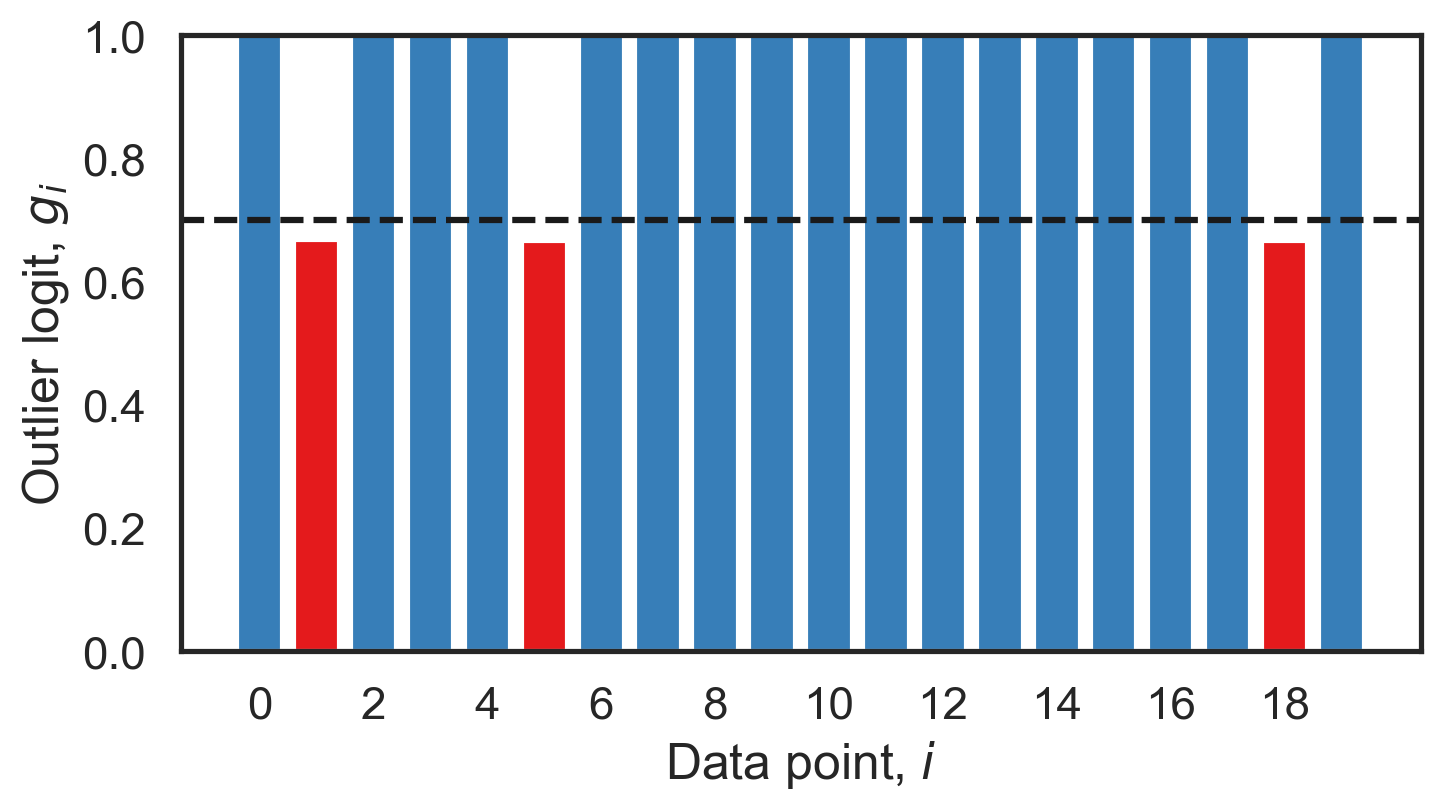

In [62]:
thershold = 0.7 # Choose a thershold!

g = expit(θ_robust[2:])
outliers = g < thershold # classify outliers

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(X))[outliers], g[outliers], color=red)
plt.bar(np.arange(len(X))[~outliers], g[~outliers], color=blue)
plt.axhline(thershold, color='k', ls='--')
plt.xticks(range(0, len(X), 2))
plt.ylim(0, 1)
plt.xlabel('Data point, $i$')
plt.ylabel('Outlier logit, $g_i$');

Finally, we can see how the different models compare in terms of model fitting.

Importantly, we can mark the predicted outliers: data points for which $g_i$ is below some threshold.

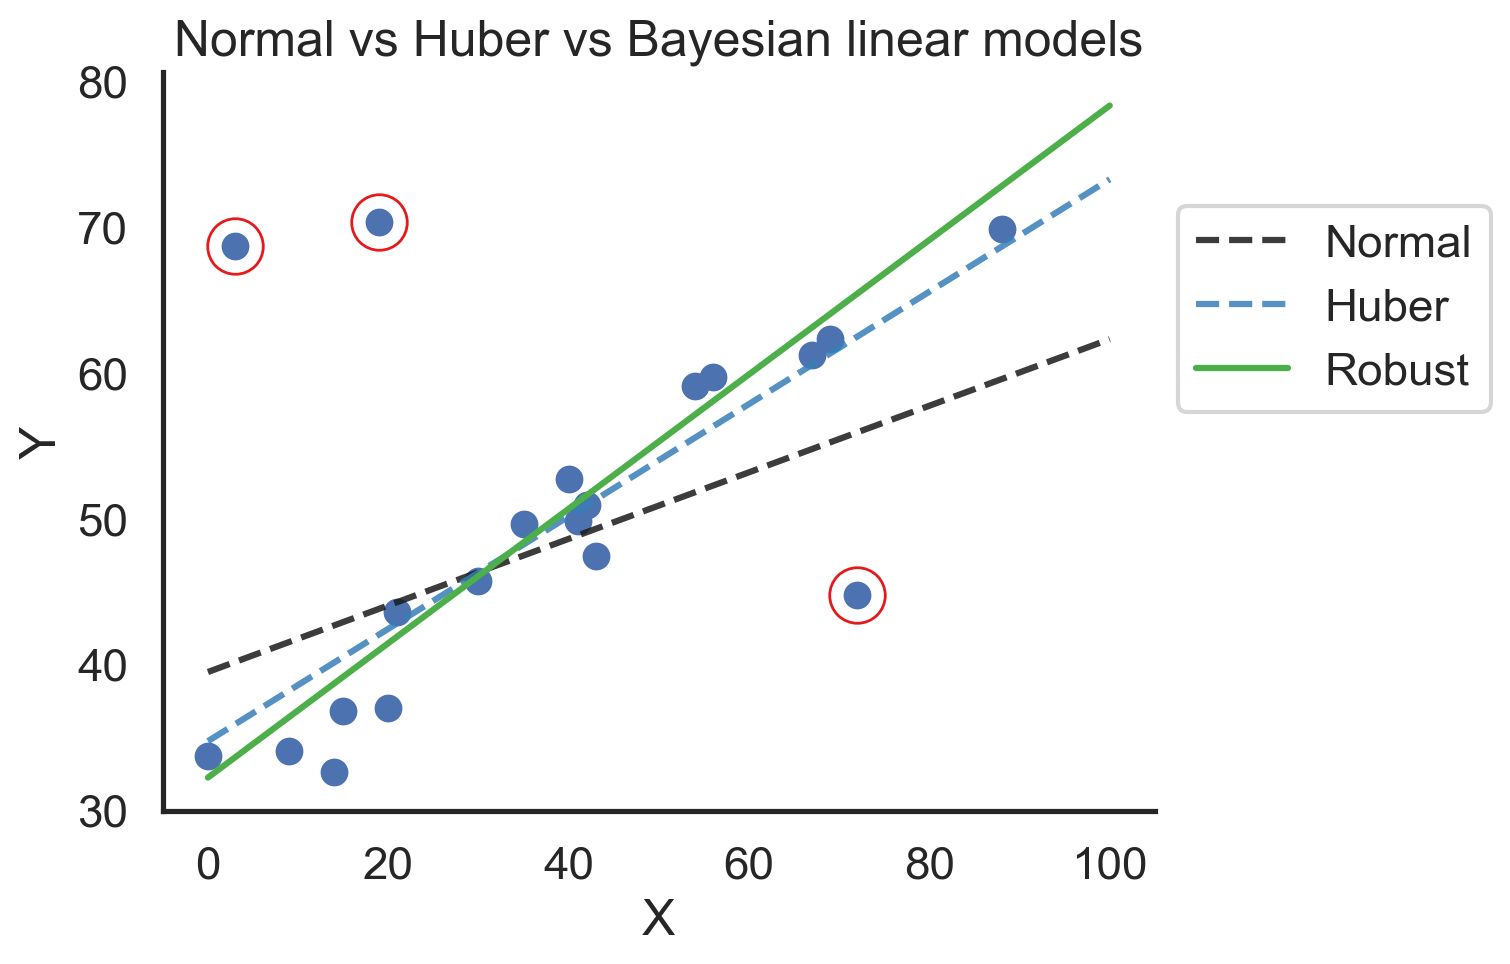

In [63]:
plt.plot(X, Y, 'o')
plt.plot(x_range, θ_norm[1] + θ_norm[0] * x_range, ls='--', alpha=0.85, label='Normal', color='k')
plt.plot(x_range, θ_huber[1] + θ_huber[0] * x_range, ls='--', alpha=0.85, label='Huber', color=blue)
plt.plot(x_range, θ_robust[1] + θ_robust[0] * x_range, label='Robust', color=green)
plt.plot(X[outliers], Y[outliers], 'ro', ms=20, mfc='none', mec=red)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(bbox_to_anchor=(1, 0.85))
plt.title('Normal vs Huber vs Bayesian linear models')
sns.despine()

Amazingly, the robust linear model produces a much better fit and also identifies as outliers mostly the points that we would identify by the "eye test".

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)